In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from  scipy.stats import binom

# Problem

Designing a sugar cane farm in Minecraft requires deciding how often to harvest sugarcane. Harvesting sugarcane immediately after it grows gives optimal yeild, but is impractical for large farms. Because harvesting sugar cane at the wrong time can "waste" some random ticks a growing sugar cane has recived, yield is not a monotonic function of harvest period.

Given this, what is the optimal harvest period to maximize yeild?

# Background

Sugar cane plants can grow up to three blocks tall. For a new block of sugar cane to grow, the top block of a plant must be "random ticked" 16 times.

Each game tick, 3 random blocks are independently sampled from each 16×16×16 sub-chunk to be random ticked. Since the samples are independent, a block can be random ticked up to 3 times per game tick. The chance any given block is random ticked for a given sample is $16^{-3}$.

# Analysis

## Average growth rate of first harvest

We will consider only one sugar cane plant for simplicity. Since sugar cane grow practically independently, the growth rate of $n$ sugar cane is rougly equal to $n$ times the growth rate of one sugar cane.

We'd like to know the number of random ticks a sugar can plant recieves over a given period of time. This quantity, which we will call $T_0$ is a random variable. The number of occurences of an independent random trial (such as a random tick) repeated $n$ times is described by a [Binomial distribution][1]. $\text{P}(T_0 = r)$ is plotted below for a 25 minute interval, that is, the proability that $T_0 = r$ where $r$ is a given number of random ticks recieved.

[1]: https://en.wikipedia.org/wiki/Binomial_distribution

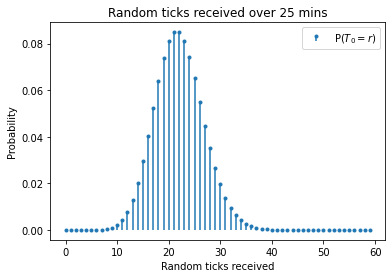

In [2]:
T_0_dist = binom(60*60*25, 16**-3)
random_ticks = np.arange(0, 60)
T_0 = T_0_dist.pmf(random_ticks)
plt.stem(random_ticks, T_0, markerfmt='.', basefmt=' ')
plt.legend([r'P$(T_0 = r)$'])
plt.xlabel("Random ticks received")
plt.ylabel("Probability")
plt.title("Random ticks received over 25 mins")
plt.show()

The average number of random ticks recieved over the period, also called the expected value of $T_0$, or $\text{E}(T_0)$, is the sum of each random ticks received value times its probability of ocurring. This sum is represented as the shaded region of the plot above.

In [3]:
expected_value = (random_ticks * T_0).sum()
print(f"Expected random ticks recieved: {expected_value:0.2f}")

Expected random ticks recieved: 21.97


If we harvest once after waiting 25 minutes, we can expect 21.97 random ticks on average.

## Average growth rate over many harvests

However, if we harvest repeatedly, we must also account for any random ticks recived during a previous harvest period, since there may be random ticks left over. Specifically, if the previous harvest had zero growths the random ticks from the previous harvest are not reset.

Given the two possibilities for the previous harvest, zero growths or non-zero growths, the total random ticks recieved $T_n$ for a harvest $n$ is:

$T_n = T_0 + T_{n - 1} 1_{T_{n - 1} < 16}$

Where $1_{T_n < 16}$ is a random variable which is 1 if $T_n < 16$ and $0$ otherwise.

Since harvesting will eventually reach a steady state where $T_n = T_{n - 1}$, the equation simplifies to:

$T_n = T_0 + T_n 1_{T_n < 16}$

We can solve for $T_n$ numerically, by iterating the operation on the right hand side starting at $T_n \approx T_0$ until the change is small. The resulting distribution for $T_n$ with a 25 minute harvest period is plotted below.

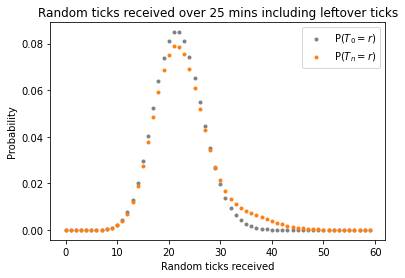

In [4]:
def compute_T_n(T_0):
    T_prev = np.zeros_like(T_0)
    T_n = T_0
    while np.linalg.norm(T_n - T_prev) > 0.000001:
        T_prev = T_n
        T_n_prime = T_n.copy()
        T_n_prime[16:] = 0
        T_n_prime[0] += T_n[16:].sum()
        T_n = np.convolve(T_0, T_n_prime, mode='full')[:len(T_0)]
        T_n /= T_n.sum() # renormalize to counteract error
    return T_n
T_n = compute_T_n(T_0)
plt.scatter(random_ticks, T_0, c='grey', marker='.')
plt.scatter(random_ticks, T_n, c='C1', marker='.')
plt.legend([r'P$(T_0 = r)$', r'P$(T_n = r)$'])
plt.xlabel("Random ticks received")
plt.ylabel("Probability")
plt.title("Random ticks received over 25 mins including leftover ticks")
plt.show()

Notice that $T_n$ (orange) has a higher chance to have recived 30 to 50 random tick compared to $T_0$ (grey).

We can compute the expected sugar cane growth by computing the probability of three seperate ranges of $T_n$:

$\begin{align}
T_n& \lt 16 \\
16 \le T_n& \lt 32 \\
32 \le T_n&
\end{align}$

These ranges are plotted below.

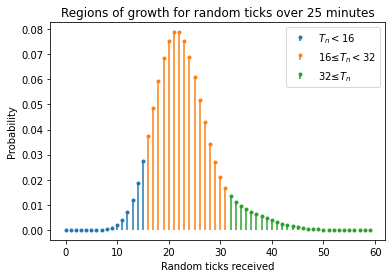

Probability of no growths: 7.21%
Probability of one growths: 84.68%
Probability of two growths: 8.10%

Expected number of growths over 25 minutes: 1.01


In [5]:
def probabilities(sample_count):
    T_0_dist = binom(sample_count, 16**-3)
    random_ticks = np.arange(0, max(24, T_0_dist.ppf(0.999999)))
    T_0 = T_0_dist.pmf(random_ticks)
    T_n = compute_T_n(T_0)
    chance_no_growth = T_n[:16].sum()
    chance_one_growth = T_n[16:32].sum()
    chance_two_growths = 1 - (chance_no_growth + chance_one_growth)
    return (chance_no_growth, chance_one_growth, chance_two_growths)


def expected_growth(sample_count):
    return (np.arange(0, 3) * probabilities(sample_count)).sum()
expected_growth = np.vectorize(expected_growth)

plt.stem(random_ticks[:16], T_n[:16], linefmt='C0', markerfmt='C0.', basefmt=' ')
plt.stem(random_ticks[16:32], T_n[16:32], linefmt='C1', markerfmt='C1.', basefmt=' ')
plt.stem(random_ticks[32:], T_n[32:], linefmt='C2', markerfmt='C2.', basefmt=' ')
plt.legend([
    r'$T_n < 16$',
    r'$16 ≤ T_n < 32$',
    r'$32 ≤ T_n$',
])
plt.xlabel("Random ticks received")
plt.ylabel("Probability")
plt.title("Regions of growth for random ticks over 25 minutes")
plt.show()

probability_no_growths, probability_one_growth, probability_two_growths = probabilities(60*60*25)
print(f"Probability of no growths: {probability_no_growths:0.2%}")
print(f"Probability of one growths: {probability_one_growth:0.2%}")
print(f"Probability of two growths: {probability_two_growths:0.2%}")
print()
print(f"Expected number of growths over 25 minutes: {expected_growth(60*60*25):0.2f}")

Using the expected growths, we can plot the expected number of growths for harvest periods up to one hour (after which, the expected value is almost 2.00).

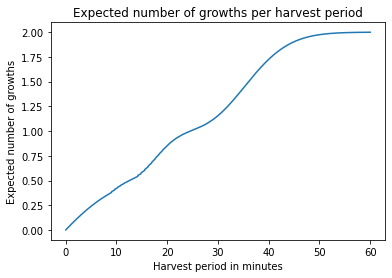

In [6]:
sample_counts = np.arange(60, 60*60*60, 100)
expected_growths = expected_growth(sample_counts)

minutes = sample_counts / 60 / 60
plt.plot(minutes, expected_growths)
plt.xlabel("Harvest period in minutes")
plt.ylabel("Expected number of growths")
plt.title("Expected number of growths per harvest period")
plt.show()

Finally, to get the expected *rate* of growth, if the sugar cane plant is harvested every $n$ minutes, we divide the expected number of growths after $n$ minutes by the number of minutes.

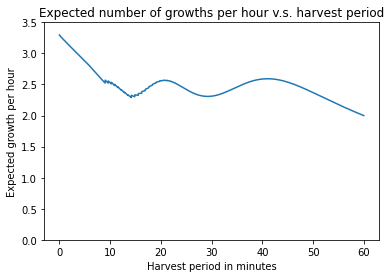

In [7]:
expected_growths_per_minute = expected_growths / minutes
plt.plot(minutes, expected_growths_per_minute * 60)
plt.xlabel("Harvest period in minutes")
plt.ylabel("Expected growth per hour")
plt.title("Expected number of growths per hour v.s. harvest period")
plt.ylim(0, 3.5)
plt.show()

We can visually see three rough maxima: a global maximum when harvesting every tick, and two local maxima at about 21 minutes, and 41 minutes. After the second local maximum, the rate slowly tapers off roughly in proportion with the inverse of the harvest period. The global maximum can be computed analytically, and the two local maxima can be comuted numerically.

As discussed in the problem statement, harvesting sugar cane immediately after it grows gives the ideal maximum yeild. The maximum yeild is easily computed as the number of random ticks in an hour times the chance of a reciving a single random tick devided by 16 ticks per growth.

In [8]:
maximum_growth_per_hour = 60*60*60 * 16**-3 / 16
print(f"Maximum growth per hour: {maximum_growth_per_hour:0.2f}")

Maximum growth per hour: 3.30


The first local maximum occurs just after the average time it takes sugar cane to grow one stage. Harvesting just before a sugar cane grows means that it will grow soon after the havest and barely not grow a second time before the next harvest, wasting almost 16 ticks. Since this would happen every other cycle, the first local minimum is about $2 / 3$ of the global maximum.

The time of and growth rate at the first local maximum is computed below.

In [9]:
sample_counts = np.arange(60*60*20, 60*60*22)
minutes_first_max = sample_counts / 60 / 60
expected_growths = expected_growth(sample_counts)
expected_growths_per_minute_first_max = expected_growths / minutes_first_max

max_expected_growth_rate = expected_growths_per_minute_first_max.argmax()
period_of_first_max = minutes_first_max[max_expected_growth_rate]
growth_rate_of_first_max = expected_growths_per_minute_first_max[max_expected_growth_rate]

print(f"Period of first local maximum: {period_of_first_max:0.2f} min")
print(f"Growth rate at first local maximum: {growth_rate_of_first_max * 60:0.2f} sugar cane per hour")

Period of first local maximum: 20.51 min
Growth rate at first local maximum: 2.57 sugar cane per hour


The second local maximum has a similar explanation, except caused by the sugar cane's second growth instead of its first. It's computed below and its growth rate is slightly higher than the first maximum's.

In [10]:
sample_counts = np.arange(60*60*40, 60*60*42)
minutes_second_max = sample_counts / 60 / 60
expected_growths = expected_growth(sample_counts)
expected_growths_per_minute_second_max = expected_growths / minutes_second_max

max_expected_growth_rate = expected_growths_per_minute_second_max.argmax()
period_of_second_max = minutes_second_max[max_expected_growth_rate]
growth_rate_of_second_max = expected_growths_per_minute_second_max[max_expected_growth_rate]

print(f"Period of second local maximum: {period_of_second_max:0.2f} min")
print(f"Growth rate at second local maximum: {growth_rate_of_second_max * 60:0.2f} sugar cane per hour")

Period of second local maximum: 41.04 min
Growth rate at second local maximum: 2.59 sugar cane per hour


# Conclusion

The optimal harvest period for sugar cane, outside of impractically frequent harvests, is about 41 minutes. The next best period is about 21 minutes. The growth rate vs harvest period is plotted below.

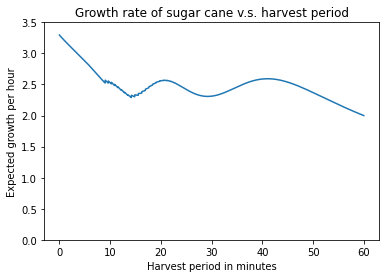

Maximum growth per hour (harvest every tick): 3.30

Period of first local maximum: 20.51 min
Growth rate at first local maximum: 2.57 sugar cane per hour per plant

Period of second local maximum: 41.04 min
Growth rate at second local maximum: 2.59 sugar cane per hour per plant


In [11]:
plt.plot(minutes, expected_growths_per_minute * 60)
plt.xlabel("Harvest period in minutes")
plt.ylabel("Expected growth per hour")
plt.title("Growth rate of sugar cane v.s. harvest period")
plt.ylim(0, 3.5)
plt.show()

print(f"Maximum growth per hour (harvest every tick): {maximum_growth_per_hour:0.2f}")
print()
print(f"Period of first local maximum: {period_of_first_max:0.2f} min")
print(f"Growth rate at first local maximum: {growth_rate_of_first_max * 60:0.2f} sugar cane per hour per plant")
print()
print(f"Period of second local maximum: {period_of_second_max:0.2f} min")
print(f"Growth rate at second local maximum: {growth_rate_of_second_max * 60:0.2f} sugar cane per hour per plant")

<p>
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="https://licensebuttons.net/p/zero/1.0/80x15.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <a rel="dct:publisher"
     href="https://gist.github.com/GrantMoyer">
    <span property="dct:title">Grant Moyer</span></a>
  has waived all copyright and related or neighboring rights to
  <span property="dct:title"> Sugar Cane Yield v.s. Harvest Period</span>.
This work is published from:
<span property="vcard:Country" datatype="dct:ISO3166"
      content="US" about="https://gist.github.com/GrantMoyer">
  United States</span>.
</p>